<a href="https://colab.research.google.com/github/farazzashraf/gender_detection_model/blob/main/Gender_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Step 1: Ensure GPU is available and configure memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set the first GPU visible
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth to prevent OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Using GPU: {logical_gpus}")
    except RuntimeError as e:
        print(f"Error setting GPU: {e}")
else:
    print("No GPU detected. Using CPU.")

# Step 2: Enable mixed precision (set before model creation)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yuulind/imdb-clean")

print("Path to dataset files:", path)

Resuming download from 758120448 bytes (6577622007 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/yuulind/imdb-clean?dataset_version_number=1 (758120448/7335742455) bytes left.


100%|██████████| 6.83G/6.83G [05:27<00:00, 20.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yuulind/imdb-clean/versions/1


In [ ]:
#Gender Model

import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV files (adjust paths as necessary)
train_csv_path = "/root/.cache/kagglehub/datasets/yuulind/imdb-clean/versions/1/imdb_train_new_1024.csv"
valid_csv_path = "/root/.cache/kagglehub/datasets/yuulind/imdb-clean/versions/1/imdb_valid_new_1024.csv"
test_csv_path = "/root/.cache/kagglehub/datasets/yuulind/imdb-clean/versions/1/imdb_test_new_1024.csv"


# Read CSV files into pandas DataFrames
train_data = pd.read_csv(train_csv_path)
valid_data = pd.read_csv(valid_csv_path)
test_data = pd.read_csv(test_csv_path)

# Display the first few rows of the train data
print(train_data.head())

# Prepare the labels
def prepare_labels(df):
    # ages = df['age'].values
    genders = df['gender'].apply(lambda x: 1 if x == 'M' else 0).values  # Convert 'M' to 1 and 'F' to 0

    return genders

train_genders = prepare_labels(train_data)
valid_genders = prepare_labels(valid_data)
test_genders = prepare_labels(test_data)


# Check prepared labels
# print(f"Train ages: {train_ages[:5]}")
print(f"Train genders: {train_genders[:5]}")


                                        filename  age gender  x_min  y_min  \
0  05/nm0200005_rm3512895744_1959-12-24_2009.jpg   50      M   78.0   93.0   
1   02/nm0001002_rm1464638208_1966-7-31_2006.jpg   40      M  123.0  175.0   
2     00/nm0000100_rm103389184_1955-1-6_2005.jpg   50      M   52.0   70.0   
3   04/nm0024404_rm2909178368_1978-2-20_2009.jpg   31      F   28.0   38.0   
4      00/nm0703800_rm31823616_1959-6-6_2008.jpg   49      M   69.0  100.0   

   x_max  y_max  head_roll   head_yaw  head_pitch  
0  155.0  185.0  20.134891 -34.811884   -5.720485  
1  245.0  349.0  11.789708  23.570937  -18.610900  
2  103.0  139.0   0.209951 -20.153913  -13.759556  
3   55.0   75.0   9.971704 -10.203414   -1.376687  
4  137.0  199.0   5.041017  14.441552   12.871575  
Train genders: [1 1 1 0 1]


In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_and_crop_face(filename, x_min, y_min, x_max, y_max, dataset_base_path):
    """
    Load an image and crop it using the bounding box coordinates.
    """
    img_path = os.path.join(dataset_base_path, filename)

    # Load the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image not found: {img_path}")
        return None

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop the face region using the bounding box coordinates
    cropped_face = image[int(y_min):int(y_max), int(x_min):int(x_max)]

    return cropped_face

def preprocess_image(image, target_size=(224, 224)):
    """
    Preprocess the image by resizing and normalizing pixel values.
    """

    if len(image.shape) == 2 or image.shape[-1] != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)

    # Normalize the image to [0, 1] range by dividing by 255
    normalized_image = resized_image / 255.0

    # Ensure image is RGB
    if len(image.shape) == 2 or image.shape[-1] != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return normalized_image

# Create an image data generator
def create_image_generator(image_paths, genders, x_mins, y_mins, x_maxs, y_maxs, batch_size=32, target_size=(224, 224), shuffle=True, dataset_base_path='/root/.cache/kagglehub/datasets/yuulind/imdb-clean/versions/1/imdb-clean-1024/imdb-clean-1024', sample_size=None):
    while True:
        # Shuffle the data if needed
        if sample_size is not None:
            indices = np.random.choice(len(image_paths), size=min(sample_size, len(image_paths)), replace=False)
            image_paths = image_paths[indices]
            genders = genders[indices]
            x_mins = x_mins[indices]
            y_mins = y_mins[indices]
            x_maxs = x_maxs[indices]
            y_maxs = y_maxs[indices]

        for i in range(0, len(image_paths), batch_size):
            # Get the batch of image file paths and corresponding bounding boxes and labels
            batch_paths = image_paths[i:i+batch_size]
            batch_genders = genders[i:i+batch_size]
            batch_x_mins = x_mins[i:i+batch_size]
            batch_y_mins = y_mins[i:i+batch_size]
            batch_x_maxs = x_maxs[i:i+batch_size]
            batch_y_maxs = y_maxs[i:i+batch_size]

            # Load, crop, and preprocess the images
            batch_images = []
            for j in range(len(batch_paths)):
                img_path = batch_paths[j]
                x_min, y_min, x_max, y_max = batch_x_mins[j], batch_y_mins[j], batch_x_maxs[j], batch_y_maxs[j]

                # Load and crop the face from the image
                cropped_face = load_and_crop_face(img_path, x_min, y_min, x_max, y_max, dataset_base_path)
                if cropped_face is not None:
                    # Preprocess the cropped face
                    preprocessed_face = preprocess_image(cropped_face, target_size)
                    batch_images.append(preprocessed_face)

            # Convert the list of images to a tensor
            batch_images = tf.convert_to_tensor(batch_images)

            # Get the corresponding labels (gender)
            batch_genders = tf.convert_to_tensor(batch_genders)

            # Yield the batch of images and labels
            yield batch_images, batch_genders

# Example: Prepare the data
train_image_paths = train_data['filename'].values
valid_image_paths = valid_data['filename'].values
test_image_paths = test_data['filename'].values

train_genders = prepare_labels(train_data)
valid_genders = prepare_labels(valid_data)
test_genders = prepare_labels(test_data)

# Prepare the bounding box coordinates
train_x_mins = train_data['x_min'].values
train_y_mins = train_data['y_min'].values
train_x_maxs = train_data['x_max'].values
train_y_maxs = train_data['y_max'].values

valid_x_mins = valid_data['x_min'].values
valid_y_mins = valid_data['y_min'].values
valid_x_maxs = valid_data['x_max'].values
valid_y_maxs = valid_data['y_max'].values

test_x_mins = test_data['x_min'].values
test_y_mins = test_data['y_min'].values
test_x_maxs = test_data['x_max'].values
test_y_maxs = test_data['y_max'].values

sample_size=3500

# Create the generators for training, validation, and test sets
train_generator = create_image_generator(train_image_paths, train_genders, train_x_mins, train_y_mins, train_x_maxs, train_y_maxs, sample_size=sample_size, batch_size=32)
valid_generator = create_image_generator(valid_image_paths, valid_genders, valid_x_mins, valid_y_mins, valid_x_maxs, valid_y_maxs, sample_size=sample_size, batch_size=32)
test_generator = create_image_generator(test_image_paths, test_genders, test_x_mins, test_y_mins, test_x_maxs, test_y_maxs, sample_size=sample_size, batch_size=32)



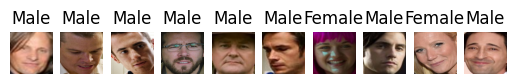

In [ ]:
# To visualize a few sample images, here’s an example:
def visualize_samples(generator, n_samples=5):
    images, labels = next(generator)  # Get a batch of images
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i])  # Visualize the image
        plt.title("Male" if labels[i] == 1 else "Female")  # Title based on label
        plt.axis('off')
    plt.show()

# Visualizing a few samples from the train_generator
visualize_samples(train_generator, n_samples=10)

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Step 1: Ensure GPU is available and configure memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set the first GPU visible
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth to prevent OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Using GPU: {logical_gpus}")
    except RuntimeError as e:
        print(f"Error setting GPU: {e}")
else:
    print("No GPU detected. Using CPU.")

# Step 2: Enable mixed precision (set before model creation)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
# Check and enable GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Using GPU: {logical_gpus}")
    except RuntimeError as e:
        print(f"Error setting GPU: {e}")
else:
    print("No GPU detected. Using CPU.")
# Enable mixed precision if supported
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
# Data Augmentation Function
def create_data_augmentation():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.3),
        layers.RandomContrast(0.3),
        layers.RandomCrop(height=224, width=224),
        layers.GaussianNoise(0.1),  # Gaussian noise for robustness
    ])
# Learning Rate Schedule
def lr_schedule(epoch):
    """Learning rate schedule"""
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01
# CNN Model Definition for Gender Classification
def build_gender_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    # First Conv Block
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    # Second Conv Block
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    # Third Conv Block
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    # Flatten the output and add Fully Connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    # Gender prediction branch
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid', name="gender"))
    return model
# Compile the model
def compile_model(model, initial_learning_rate=0.001):
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
# Define Callbacks
def create_callbacks(model_name="gender_model"):
    return [
        # Early Stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        # Learning Rate Scheduler
        LearningRateScheduler(lr_schedule),
        # Reduce Learning Rate on Plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        ),
        # Model Checkpointing
        tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_best.keras',
            monitor='val_loss',
            save_best_only=True
        ),
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./logs/{model_name}',
            histogram_freq=1
        )
    ]

In [ ]:
model = build_gender_model(input_shape=(224, 224, 3))
compile_model(model, initial_learning_rate=0.001)
# Calculate steps_per_epoch
steps_per_epoch = 3500 // 32  # 109 steps per epoch (rounded down)
batch_size = 32
validation_steps = 3500 // batch_size
model.fit(train_generator, epochs=50, validation_data=valid_generator,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          callbacks=create_callbacks())

# Save the model to disk
model.save('gender_detection_model.h5')  # You can specify any filename and path you prefer

In [ ]:
import tensorflow as tf
# Now you can load the model and other components
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("drive/MyDrive/Models/gender_model_best.keras")
# Check the model summary to verify it loaded correctly
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │              

 Total params: 154,824,645 (590.61 MB)

 Trainable params: 51,607,553 (196.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 103,215,108 (393.73 MB)

In [ ]:


# Now you can load the model and other components
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/gender_model_best.keras")
# Check the model summary to verify it loaded correctly
model.summary()


# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_data) // 32, verbose=1)

# Display results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │              

 Total params: 154,824,649 (590.61 MB)

 Trainable params: 51,607,553 (196.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 103,215,112 (393.73 MB)

1752/1752 ━━━━━━━━━━━━━━━━━━━━ 3834s 2s/step - accuracy: 0.8844 - loss: 0.2640
Test Accuracy: 88.43%
Test Loss: 0.2645


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# GPU and Mixed Precision Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Using GPU: {logical_gpus}")
        # Enable memory growth to prevent OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting GPU: {e}")
else:
    print("No GPU detected. Using CPU.")

# Enable mixed precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Extract all true labels and predictions from the generator
true_labels = []
predicted_labels = []

test_generator = create_image_generator(test_image_paths, test_genders, test_x_mins, test_y_mins, test_x_maxs, test_y_maxs, sample_size=1000, batch_size=32)


# Manually process the entire test dataset
for batch_images, batch_genders in test_generator:
    # Collect true labels
    true_labels.extend(batch_genders.numpy())  # Convert Tensor to NumPy array

    # Predict on batch
    predictions = model.predict(batch_images)

    # Convert predictions to binary (Male = 1, Female = 0)
    predicted_labels_batch = (predictions.flatten() >= 0.5).astype(int)
    predicted_labels.extend(predicted_labels_batch)

    # Exit loop when the number of true labels reaches sample_size
    if len(true_labels) >= sample_size:
        break

# Convert lists to numpy arrays
true_labels = np.array(true_labels[:sample_size])  # Ensure we only use the sample size
predicted_labels = np.array(predicted_labels[:sample_size])

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)


No GPU detected. Using CPU.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Male', 'Female'])

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        Male       0.86      0.90      0.88      1407
      Female       0.93      0.90      0.92      2093

    accuracy                           0.90      3500
   macro avg       0.90      0.90      0.90      3500
weighted avg       0.90      0.90      0.90      3500



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


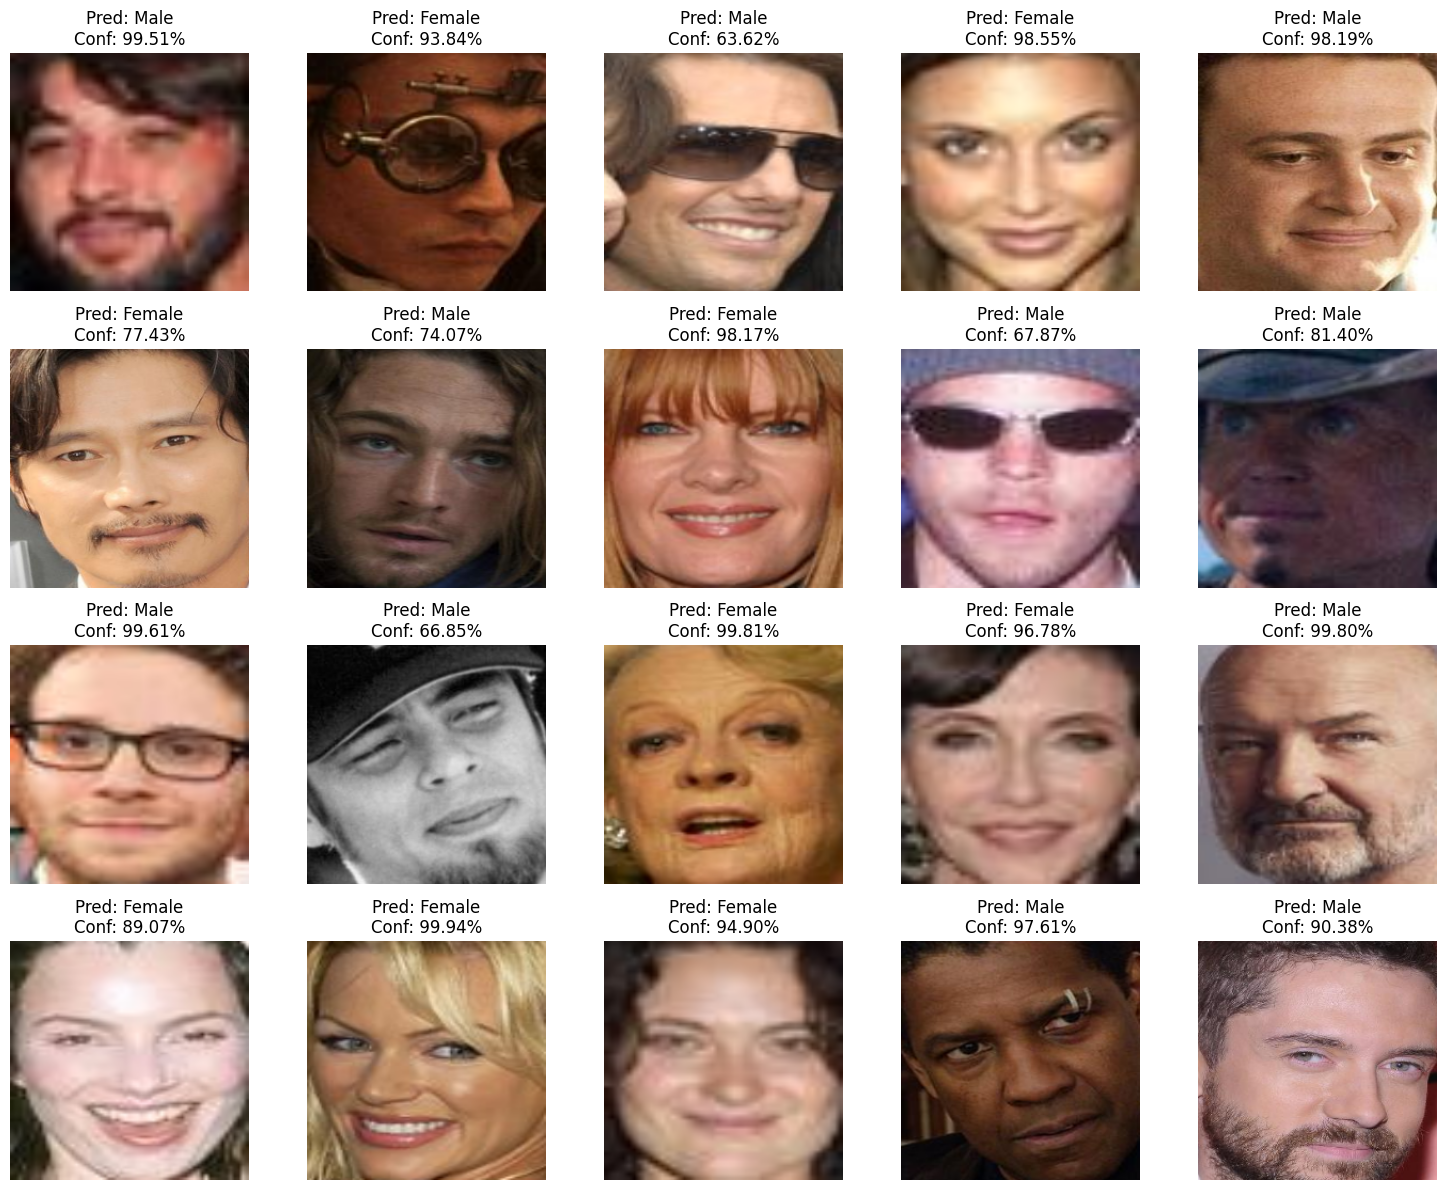

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import os

# Number of images to display
num_images = 20
images_per_row = 5  # 5 images per row

# Calculate the number of rows needed
num_rows = (num_images + images_per_row - 1) // images_per_row  # Round up to ensure enough rows

# Initialize a figure for plotting
plt.figure(figsize=(15, num_rows * 3))  # Adjust the height of the figure based on the number of rows

# Start iterating through the test generator
for i, (batch_images, batch_genders) in enumerate(test_generator):
    # Predict the batch
    predictions = model.predict(batch_images)

    # Loop over the batch of images and their predictions
    for j in range(min(num_images, len(batch_images))):
        # Get the predicted class (Male=1, Female=0) and confidence score
        predicted_class = "Male" if predictions[j] >= 0.5 else "Female"
        confidence_score = predictions[j][0] if predictions[j] >= 0.5 else 1 - predictions[j][0]

        # Get the image and convert it back to RGB from the preprocessing step
        image = batch_images[j].numpy()
        image = np.clip(image * 255.0, 0, 255).astype(np.uint8)  # Rescale back to [0, 255]

        # Determine row and column for the subplot
        row = j // images_per_row  # Determine which row to place the image in
        col = j % images_per_row  # Determine the column in the current row

        # Display the image with prediction label and confidence
        plt.subplot(num_rows, images_per_row, row * images_per_row + col + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Pred: {predicted_class}\nConf: {confidence_score*100:.2f}%")

    # Stop after displaying the required number of images
    if i * len(batch_images) >= num_images:
        break

# Show the plot
plt.tight_layout()
plt.show()


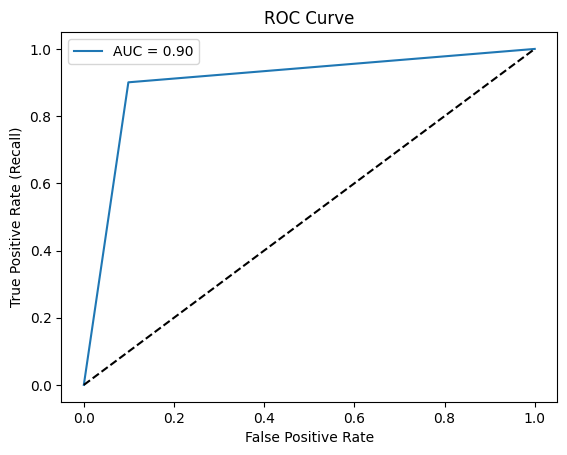

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()


In [ ]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(true_labels, predicted_labels)
print(f"MCC: {mcc}")


MCC: 0.7960955308451241


In [ ]:
from sklearn.metrics import log_loss
loss = log_loss(true_labels, predicted_labels)
print(f"Log Loss: {loss}")


Log Loss: 3.5734707788639004


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# Load your model (make sure the model is saved and loaded correctly)
model = tf.keras.models.load_model('/content/drive/MyDrive/Models/gender_model_best.keras')  # Update this path to your model

# Define the image preprocessing function
def preprocess_image(img):
    # Convert the uploaded image to RGB format (Gradio loads it as a PIL image)
    img = np.array(img.convert("RGB"))
    img = cv2.resize(img, (224, 224))  # Resize the image to match model input size (224x224 as an example)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Define the prediction function
def predict_gender(img):
    # Preprocess the image
    processed_image = preprocess_image(img)

    # Make the prediction
    prediction = model.predict(processed_image)

    # Determine predicted gender and confidence score
    predicted_class = "Male" if prediction[0] >= 0.5 else "Female"
    confidence_score = prediction[0] if prediction[0] >= 0.5 else 1 - prediction[0]

    return f"Predicted Gender: {predicted_class}\nConfidence: {confidence_score*100:.2f}%"

# Define Gradio interface without the 'shape' argument
iface = gr.Interface(fn=predict_gender,
                     inputs=gr.Image(type="pil"),  # No need for 'shape'
                     outputs=gr.Textbox(),
                     title="Age and Gender Prediction",
                     description="Upload an image to predict the gender with confidence score.",
                     live=True)

# Launch the Gradio app
iface.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
pip install gradio==3.24  # or any specific version you want to try

INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: markdown-it-py
    Found existing installation: markdown-it-py 3.0.0
    Uninstalling markdown-it-py-3.0.0:
      Successfully uninstalled markdown-it-py-3.0.0
  Attempting uninstall: mdit-

In [ ]:
pip install opencv-python --upgrade
